
#GNN Node Clustering - Google Colab Notebook

Complete implementation for training GNNs to cluster graph nodes.
Ready to run on Google Colab with GPU support.

To use:
1. Copy this entire file
2. Open Google Colab (colab.research.google.com)
3. Create new notebook
4. Paste code into cells as indicated below
5. Run cells in order


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- 指定数据文件储存地址 ---
import os
from pathlib import Path

# --- Project Root ---
PROJECT_ROOT = Path("/content/drive/MyDrive/GNN-MILP")

# --- Base Directories ---
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

# --- Data Subdirectories ---
RAW_DATA_DIR = DATA_DIR / "raw"
MPS_DATA_DIR = DATA_DIR / "mps"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# Install PyTorch Geometric

In [ ]:
!pip install torch
!pip install torch_geometric
!pip install scikit-learn matplotlib tqdm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4



# CELL 2: Data Generation Module



In [17]:
# 随机生成的图，和问题无关。
class SyntheticGraphGenerator:
    """
    Generates synthetic graphs with cluster structure.

    Key features:
    - Controllable number of clusters
    - Dense intra-cluster connections
    - Sparse inter-cluster connections
    - Structural node features
    """

    def __init__(self, num_clusters=3, nodes_per_cluster=8,
                 intra_cluster_prob=0.7, inter_cluster_prob=0.1):
        self.num_clusters = num_clusters
        self.nodes_per_cluster = nodes_per_cluster
        self.intra_prob = intra_cluster_prob
        self.inter_prob = inter_cluster_prob

    def generate_single_graph(self, seed=None):
        """Generate one graph."""
        if seed is not None:
            np.random.seed(seed)

        num_nodes = self.num_clusters * self.nodes_per_cluster
        labels = np.repeat(np.arange(self.num_clusters), self.nodes_per_cluster)

        # Generate edges with cluster structure
        edge_list = []
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                prob = self.intra_prob if labels[i] == labels[j] else self.inter_prob
                if np.random.rand() < prob:
                    edge_list.append([i, j])

        # Make undirected
        if len(edge_list) > 0:
            edges = np.array(edge_list)
            edges = np.vstack([edges, edges[:, [1, 0]]])
        else:
            edges = np.array([[], []]).T

        edge_index = torch.tensor(edges.T, dtype=torch.long)

        # Generate features
        features = self._generate_features(edge_index, num_nodes, labels)

        return Data(
            x=features,
            edge_index=edge_index,
            y=torch.tensor(labels, dtype=torch.long),
            num_nodes=num_nodes
        )
    # 随便找的特征。
    def _generate_features(self, edge_index, num_nodes, labels):
        """Create structural node features."""
        features = []
        for node_id in range(num_nodes):
            degree = (edge_index[0] == node_id).sum().item()
            cluster_id = labels[node_id]

            # Feature vector: [normalized_degree, cluster_hint, random_features...]
            feat = [degree / num_nodes, cluster_id / self.num_clusters]
            feat.extend(np.random.randn(8))
            features.append(feat)

        return torch.tensor(features, dtype=torch.float32)

    def generate_dataset(self, num_graphs, seed_start=0):
        """Generate multiple graphs."""
        return [self.generate_single_graph(seed=seed_start + i)
                for i in range(num_graphs)]

# Test data generation
print("Testing data generation...")
generator = SyntheticGraphGenerator(num_clusters=3, nodes_per_cluster=8)
sample_graph = generator.generate_single_graph(seed=42)
print(f"✓ Sample graph: {sample_graph.num_nodes} nodes, {sample_graph.edge_index.shape[1]} edges")
print(f"✓ Features shape: {sample_graph.x.shape}")
print(f"✓ Labels: {sample_graph.y.unique().tolist()}")

Testing data generation...
✓ Sample graph: 24 nodes, 166 edges
✓ Features shape: torch.Size([24, 10])
✓ Labels: [0, 1, 2]


# CELL 2.5: Generate CFLP data

In [ ]:
!wget https://box.nju.edu.cn/f/11bf666b61144d93abec/?dl=1 -O {PROJECT_ROOT}/generate_instance.py
!wget https://box.nju.edu.cn/f/a8f1528fded0441d9e8f/?dl=1 -O {PROJECT_ROOT}/generate_dataset.py
!wget https://box.nju.edu.cn/f/530b1a9a93ae4f90b145/?dl=1 -O {PROJECT_ROOT}/train_gnn.py

In [7]:
# 选择生成的算例的数量和参数
# ratio 是设施选址中设施总容量和客户总需求量的比值；dimension 是设施和客户的数量
INSTANCE_GEN = {
    'facilities': {
        'train': {'n_instances': 2500, 'dimension': 40, 'ratio': 6},
        'valid': {'n_instances': 500, 'dimension': 40, 'ratio': 6},
        'test': {'n_instances': 500, 'dimension': 40, 'ratio': 6},
        'transfer_40': {'n_instances': 100, 'dimension': 40, 'ratio': 6},
        'transfer_30': {'n_instances': 100, 'dimension': 30, 'ratio': 6},
        'transfer_35': {'n_instances': 100, 'dimension': 35, 'ratio': 6},
        'transfer_50': {'n_instances': 100, 'dimension': 50, 'ratio': 6},
        'transfer_80': {'n_instances': 100, 'dimension': 80, 'ratio': 6},
        'transfer_100': {'n_instances': 100, 'dimension': 100, 'ratio': 6},
    },
}

In [ ]:
# 无需改动，一键运行生成算例
from generate_instance import generate_capacited_facility_location
import shutil
import numpy as np

generation_specs = INSTANCE_GEN.get('facilities', {})
base_dir = RAW_DATA_DIR

rng = np.random.RandomState(0)

for name, specs in generation_specs.items():

    n_instances = specs['n_instances']
    lp_dir = base_dir / name

    print(f"{n_instances} instances in {lp_dir}")

    if lp_dir.exists():
        shutil.rmtree(lp_dir)
    os.makedirs(lp_dir, exist_ok=True)

    for i in range(n_instances):
        print(f"  generating instance {i+1}/{n_instances}...")
        filename = lp_dir / f'instance_{i+1}.txt'
        generate_capacited_facility_location(rng, str(filename), dimension=specs['dimension'], ratio=specs['ratio'])


In [12]:
# --- Feature Extraction Parameters ---

# 生成特征中锚点的数量
FEATURE_EXTRACTION = {
    'n_anchors': 5,
}

In [10]:
!pip install gurobipy
import gurobipy as gp
params = {
    "WLSACCESSID": "4d6108da-35c3-46f3-97b2-42b8093c24fc",
    "WLSSECRET": "d2255b44-66a2-4834-9b3c-d77358096c53",
    "LICENSEID": 2561842,
}

env = gp.Env(params=params)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 83.9 MB/s eta 0:00:00
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2561842
Academic license 2561842 - for non-commercial use only - registered to 23___@smail.nju.edu.cn


In [13]:
def _process_single_file(raw_file, mps_dir, processed_dir, problem):
    print(f"  Processing {os.path.basename(raw_file)}...")
    try:
        model = CFLP_from_raw_to_mps(raw_file, mps_dir, env) # 返回 Gurobipy Model

        variables = model.getVars()
        var_names = [v.VarName for v in variables] # 保存变量名

        # 生成节点特征
        constraint_features, variable_features, edge_attr = calculate_features(model, n_anchors=FEATURE_EXTRACTION['n_anchors'])

        # 生成节点标签
        labels, mask = generate_labels(model)

        # 确保标签和特征的维度匹配
        assert variable_features.shape[0] == labels.shape[0], "特征和标签的数量不匹配！"

        # 创建 PyG 异质图对象
        data = HeteroData()

        # 将特征储存到图中
        data['constraint'].x = torch.from_numpy(constraint_features)
        data['variable'].x = torch.from_numpy(variable_features)
        data['variable'].var_names = var_names  # Store original variable names

        # 添加边
        edge_index_list = [[i, j] for i, j in edge_attr.keys()]
        edge_index_tensor = torch.tensor(list(edge_index_list)).T
        edge_attr_tensor = torch.tensor(list(edge_attr.values()))
        data['constraint', 'includes', 'variable'].edge_index = edge_index_tensor
        data['constraint', 'includes', 'variable'].edge_attr = edge_attr_tensor
        data['variable', 'in', 'constraint'].edge_index = edge_index_tensor.flip([0])
        data['variable', 'in', 'constraint'].edge_attr = edge_attr_tensor

        # 添加标签
        data['variable'].y = torch.from_numpy(labels)
        data['variable'].train_mask = torch.from_numpy(mask)

        # 保存 Data object
        instance_name = os.path.splitext(os.path.basename(raw_file))[0]
        pt_path = os.path.join(processed_dir, f"{instance_name}.pt")
        torch.save(data, pt_path)
        print(f"    Successfully saved to {pt_path}")
    except Exception as e:
        print(f"    Failed to process {raw_file}: {e}")


In [14]:
def run_preprocessing(problem, instance_dir, mps_dir, processed_dir):
    print(f"Processing Raw files from '{instance_dir}' to MPS Data in '{mps_dir}' and PyG Data in '{processed_dir}'...")

    os.makedirs(mps_dir, exist_ok=True)
    os.makedirs(processed_dir, exist_ok=True)

    raw_files = glob.glob(os.path.join(instance_dir, '*.txt'))

    # 使用多进程加速
    num_processes = multiprocessing.cpu_count()
    print(f"Starting parallel processing with {num_processes} processes...")

    worker_fn = partial(_process_single_file, mps_dir=mps_dir, processed_dir=processed_dir, problem=problem)

    with multiprocessing.Pool(processes=num_processes) as pool:
        pool.map(worker_fn, raw_files)

In [ ]:
# 生成用于训练的包含特征和标签的图数据，储存在data/processed文件夹
import glob
import multiprocessing
from torch_geometric.data import HeteroData
from functools import partial
import scipy.sparse
from scipy.sparse.csgraph import shortest_path
import networkx as nx

from generate_dataset import CFLP_from_raw_to_mps, calculate_features, generate_labels

instance_dir = str(RAW_DATA_DIR)
mps_dir = str(MPS_DATA_DIR)
processed_dir = str(PROCESSED_DATA_DIR)

instance_subdirs = glob.glob(os.path.join(instance_dir, '*'))
for subdir in instance_subdirs:
    if not os.path.isdir(subdir):
        continue

    subdir_name = os.path.basename(subdir)
    print(f"\nProcessing instance set: {subdir_name}")
    current_instance_dir = os.path.join(instance_dir, subdir_name)
    current_mps_dir = os.path.join(mps_dir, subdir_name)
    current_processed_dir = os.path.join(processed_dir, subdir_name)

    run_preprocessing('facilities', current_instance_dir, current_mps_dir, current_processed_dir)

print("\nDataset generation complete.")

# CELL 3: GNN Model Architectures

In [16]:
class SimpleGCN(nn.Module):
    """Graph Convolutional Network - Simple and effective."""

    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv2(x, edge_index)
        embeddings = F.relu(x)

        logits = self.classifier(embeddings)
        return logits, embeddings


class SimpleGAT(nn.Module):
    """Graph Attention Network - Uses attention mechanism."""

    def __init__(self, in_channels, hidden_channels, num_classes, heads=2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=0.3)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        embeddings = F.relu(x)

        logits = self.classifier(embeddings)
        return logits, embeddings


class SimpleSAGE(nn.Module):
    """GraphSAGE - Samples and aggregates neighbor features."""

    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv2(x, edge_index)
        embeddings = F.relu(x)

        logits = self.classifier(embeddings)
        return logits, embeddings


print("✓ GNN architectures defined: GCN, GAT, SAGE")


✓ GNN architectures defined: GCN, GAT, SAGE


# CELL 4: Training & Evaluation

In [18]:
class Trainer:
    """Handles model training and evaluation."""

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'val_ari': [], 'val_nmi': []
        }

    def train_epoch(self, loader, optimizer, criterion):
        """Single training epoch."""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for data in loader:
            data = data.to(self.device)
            optimizer.zero_grad()

            logits, _ = self.model(data)
            loss = criterion(logits, data.y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.num_nodes
            correct += (logits.argmax(1) == data.y).sum().item()
            total += data.num_nodes

        return total_loss / total, correct / total

    def evaluate(self, loader, criterion):
        """Evaluate on validation/test set."""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for data in loader:
                data = data.to(self.device)
                logits, _ = self.model(data)
                loss = criterion(logits, data.y)

                total_loss += loss.item() * data.num_nodes
                pred = logits.argmax(1)
                correct += (pred == data.y).sum().item()
                total += data.num_nodes

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(data.y.cpu().numpy())

        ari = adjusted_rand_score(all_labels, all_preds)
        nmi = normalized_mutual_info_score(all_labels, all_preds)

        return total_loss / total, correct / total, ari, nmi

    def train(self, train_loader, val_loader, num_epochs=50, lr=0.01):
        """Full training loop with progress bar."""
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        best_val_acc = 0

        pbar = tqdm(range(num_epochs), desc="Training")
        for epoch in pbar:
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            val_loss, val_acc, val_ari, val_nmi = self.evaluate(val_loader, criterion)

            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_ari'].append(val_ari)
            self.history['val_nmi'].append(val_nmi)

            # Save best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.best_state = self.model.state_dict()

            # Update progress bar
            pbar.set_postfix({
                'train_acc': f'{train_acc:.3f}',
                'val_acc': f'{val_acc:.3f}',
                'val_ari': f'{val_ari:.3f}'
            })

        # Restore best model
        self.model.load_state_dict(self.best_state)
        return self.history

print("✓ Trainer class ready")

✓ Trainer class ready


# CELL 5: Generate Dataset

# Configuration

In [19]:
CONFIG = {
    'num_clusters': 20,
    'nodes_per_cluster': 20,
    'num_train_graphs': 1000,
    'num_val_graphs': 100,
    'num_test_graphs': 100,
    'hidden_channels': 32,
    'num_epochs': 1000,
    'lr': 0.001,
    'batch_size': 10,
}

print("\nConfiguration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")


Configuration:
  num_clusters: 20
  nodes_per_cluster: 20
  num_train_graphs: 1000
  num_val_graphs: 100
  num_test_graphs: 100
  hidden_channels: 32
  num_epochs: 1000
  lr: 0.001
  batch_size: 10


#Generate graphs

In [ ]:
generator = SyntheticGraphGenerator(
    num_clusters=CONFIG['num_clusters'],
    nodes_per_cluster=CONFIG['nodes_per_cluster']
)

print("\nGenerating graphs...")
train_graphs = generator.generate_dataset(CONFIG['num_train_graphs'], seed_start=0)
val_graphs = generator.generate_dataset(CONFIG['num_val_graphs'], seed_start=10000)
test_graphs = generator.generate_dataset(CONFIG['num_test_graphs'], seed_start=20000)

print(f"✓ Train: {len(train_graphs)} graphs")
print(f"✓ Val: {len(val_graphs)} graphs")
print(f"✓ Test: {len(test_graphs)} graphs")

# Create dataloaders

In [ ]:
train_loader = DataLoader(train_graphs, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=CONFIG['batch_size'])
test_loader = DataLoader(test_graphs, batch_size=CONFIG['batch_size'])

print(f"\n✓ Data loaders created")

GENERATING DATASET

Configuration:
  num_clusters: 20
  nodes_per_cluster: 20
  num_train_graphs: 1000
  num_val_graphs: 100
  num_test_graphs: 100
  hidden_channels: 32
  num_epochs: 1000
  lr: 0.001
  batch_size: 10

Generating graphs...
✓ Train: 1000 graphs
✓ Val: 100 graphs
✓ Test: 100 graphs

✓ Data loaders created


# CELL 6: Train All Models

In [ ]:
in_channels = train_graphs[0].x.shape[1]
num_classes = CONFIG['num_clusters']
print(f"✓ Input channels: {in_channels}")
print(f"✓ Output classes: {num_classes}")

✓ Input channels: 10
✓ Output classes: 20


# Initialize models

In [ ]:
models = {
    'GCN': SimpleGCN(in_channels, CONFIG['hidden_channels'], num_classes),
    'GAT': SimpleGAT(in_channels, CONFIG['hidden_channels'], num_classes),
    'SAGE': SimpleSAGE(in_channels, CONFIG['hidden_channels'], num_classes),
}

results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print('='*60)

    trainer = Trainer(model, device=device)
    history = trainer.train(
        train_loader, val_loader,
        num_epochs=CONFIG['num_epochs'],
        lr=CONFIG['lr']
    )

    # Evaluate on test set
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, test_ari, test_nmi = trainer.evaluate(test_loader, criterion)

    results[name] = {
        'test_acc': test_acc,
        'test_ari': test_ari,
        'test_nmi': test_nmi,
        'history': history,
        'trainer': trainer
    }

    print(f"\n{name} Test Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  ARI: {test_ari:.4f}")
    print(f"  NMI: {test_nmi:.4f}")


Training GCN


Training: 100%|██████████| 1000/1000 [11:05<00:00,  1.50it/s, train_acc=0.174, val_acc=0.178, val_ari=0.103]



GCN Test Results:
  Accuracy: 0.1779
  ARI: 0.1048
  NMI: 0.2615

Training GAT


Training: 100%|██████████| 1000/1000 [13:54<00:00,  1.20it/s, train_acc=0.432, val_acc=0.519, val_ari=0.356]



GAT Test Results:
  Accuracy: 0.5197
  ARI: 0.3561
  NMI: 0.6073

Training SAGE


Training: 100%|██████████| 1000/1000 [09:44<00:00,  1.71it/s, train_acc=0.950, val_acc=0.400, val_ari=0.664]


SAGE Test Results:
  Accuracy: 0.4017
  ARI: 0.6630
  NMI: 0.8729


# CELL 7: Visualize Results


FINAL RESULTS COMPARISON

Model      Accuracy     ARI          NMI         
------------------------------------------------------------
GCN        0.1779       0.1048       0.2615      
GAT        0.5197       0.3561       0.6073      
SAGE       0.4017       0.6630       0.8729      


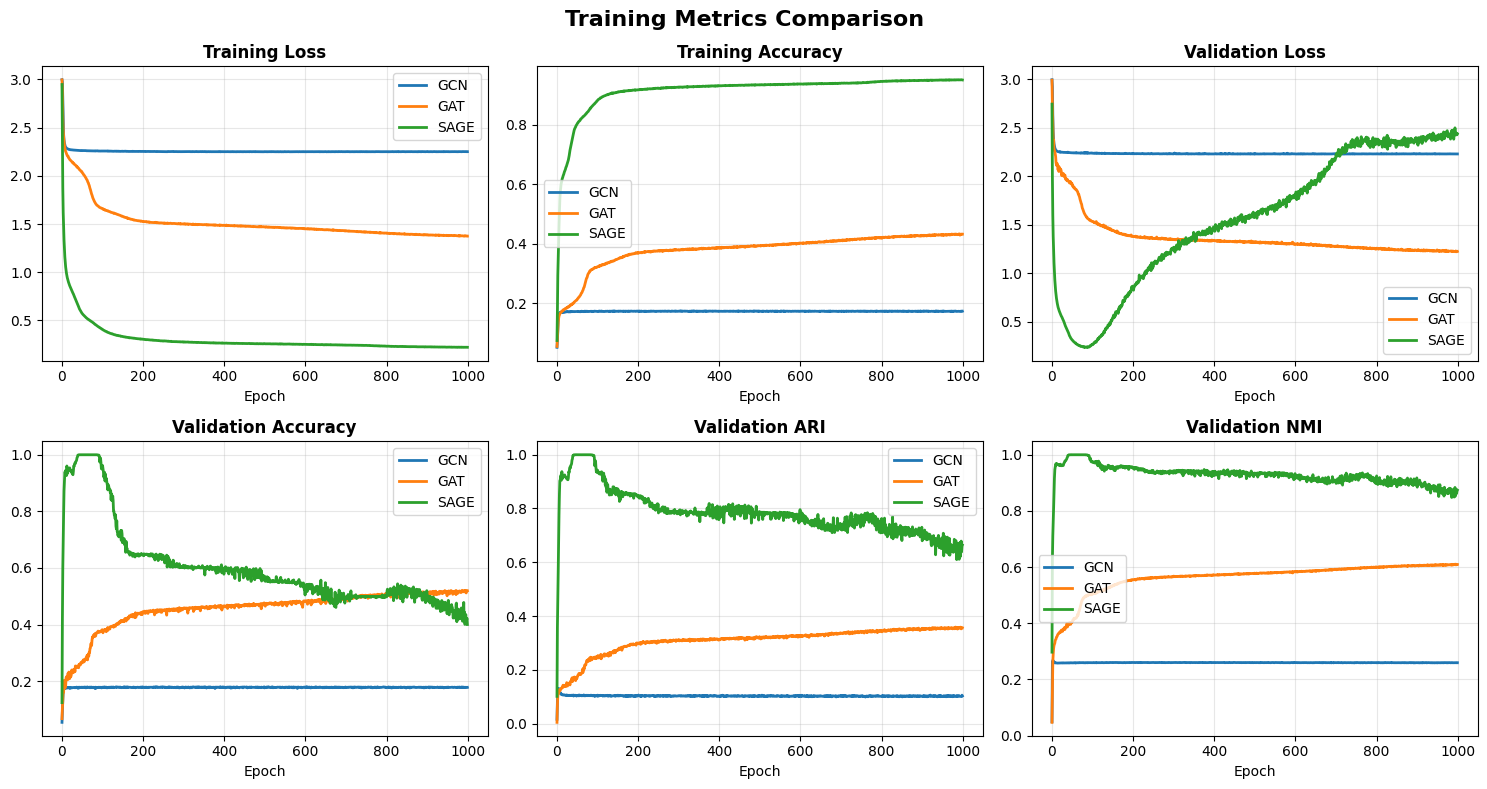

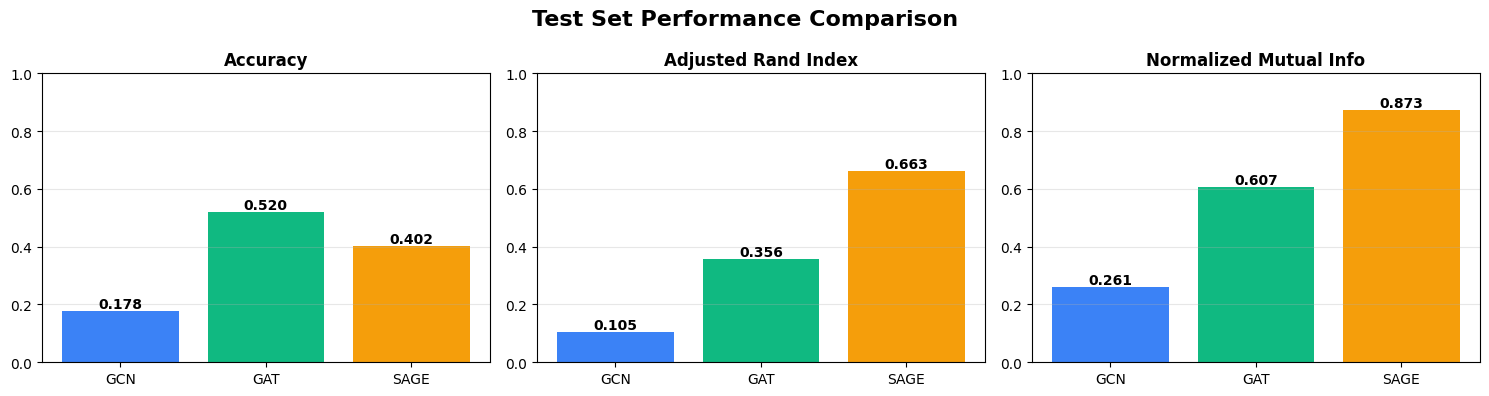


✓ All visualizations complete!


In [ ]:
print("\n" + "=" * 60)
print("FINAL RESULTS COMPARISON")
print("=" * 60)

# Print comparison table
print(f"\n{'Model':<10} {'Accuracy':<12} {'ARI':<12} {'NMI':<12}")
print("-" * 60)
for name, res in results.items():
    print(f"{name:<10} {res['test_acc']:<12.4f} {res['test_ari']:<12.4f} {res['test_nmi']:<12.4f}")

# Plot training curves for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Training Metrics Comparison', fontsize=16, fontweight='bold')

metrics = [
    ('train_loss', 'Training Loss'),
    ('train_acc', 'Training Accuracy'),
    ('val_loss', 'Validation Loss'),
    ('val_acc', 'Validation Accuracy'),
    ('val_ari', 'Validation ARI'),
    ('val_nmi', 'Validation NMI')
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    for name, res in results.items():
        ax.plot(res['history'][metric], label=name, linewidth=2)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Test Set Performance Comparison', fontsize=16, fontweight='bold')

metrics_bar = [
    ('test_acc', 'Accuracy'),
    ('test_ari', 'Adjusted Rand Index'),
    ('test_nmi', 'Normalized Mutual Info')
]

for idx, (metric, title) in enumerate(metrics_bar):
    ax = axes[idx]
    values = [results[name][metric] for name in models.keys()]
    bars = ax.bar(models.keys(), values, color=['#3b82f6', '#10b981', '#f59e0b'])
    ax.set_title(title, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ All visualizations complete!")

# CELL 8: Analyze Best Model

In [ ]:
print("\n" + "=" * 60)
print("DETAILED ANALYSIS OF BEST MODEL")
print("=" * 60)

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['test_ari'])
best_trainer = results[best_model_name]['trainer']
best_model = best_trainer.model

print(f"\nBest Model: {best_model_name}")
print(f"Test ARI: {results[best_model_name]['test_ari']:.4f}")

# Get predictions and embeddings on test set
best_model.eval()
all_preds = []
all_labels = []
all_embeddings = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        logits, embeddings = best_model(data)
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        all_embeddings.append(embeddings.cpu().numpy())

all_embeddings = np.vstack(all_embeddings)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Cluster {i}' for i in range(CONFIG['num_clusters'])],
            yticklabels=[f'Cluster {i}' for i in range(CONFIG['num_clusters'])])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualize embeddings with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     c=all_labels, cmap='viridis',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='True Cluster')
plt.title(f'Node Embeddings (PCA) - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✓ Analysis complete!")
print("\n" + "=" * 60)
print("EXPERIMENT FINISHED SUCCESSFULLY!")
print("=" * 60)